# Manuscript Content

This notebook generates all of the figures and tables for the manuscript exploring the indicators derived from the algorithm developed in this repository and their relationship with the indicators in the NSIDC-0747 dataset, currently referred to as the "Steele" indicators throughout. And appendix is provided at the end of this document. 

In [1]:
import copy
import os
import warnings
import numpy as np
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import rasterio as rio
import rioxarray
import seaborn as sns
import xarray as xr
from matplotlib.lines import Line2D
from pyproj import Transformer
from rasterio.crs import CRS
from rasterio.plot import show
from rasterstats import zonal_stats
from scipy import stats
from shapely.geometry import Polygon

In [2]:
os.environ["BASE_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data"
os.environ["OUTPUT_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products"
os.environ["SCRATCH_DIR"] = "/atlas_scratch/kmredilla/seaice_noaa_indicators"

In [3]:
def assimilate_orac(orac):
    """Replicate the data strcutre of FUBU dataset 
    in the ORAC dataset so they can be used with same functions

    Args:
        orac: Steele (NSIDC-0747) indicators xarray.dataset
        fubu: J&H indicators xarray.dataset
        
    Returns:
        ORAC dataset matching the structure of the FUBU indicators
            dataset
    """
    # retain only variables that correspond to FUBU indicators
    # rename coord vars to match
    varnames = ["DOO", "DOR", "DOA", "DOC"]
    orac = orac[varnames].rename({"x": "xc", "y": "yc", "time": "year"})
    # make time variable an integer with year
    orac = orac.assign_coords(year=[dt.year for dt in orac["year"].values])
    # set non-indicator date values to np.nan
    for var in varnames:
        orac[var].values[orac[var].values < 1] = np.nan

    return orac

In [4]:
output_dir = Path(os.getenv("OUTPUT_DIR"))
content_dir = output_dir.joinpath("manuscript_content")
content_dir.mkdir(exist_ok=True)
base_dir = Path(os.getenv("BASE_DIR"))
scratch_dir = Path(os.getenv("SCRATCH_DIR"))

In [5]:
# load data
fubu_fp = base_dir.joinpath("nsidc_0051/outputs/nsidc_0051_1979-2019_fubu.nc")

# new FUBU fp in OUTPUT_DIR
fubu_fp = output_dir.joinpath("arctic_seaice_fubu_dates_1979-2019.nc")

fubu = xr.load_dataset(fubu_fp)
# Data for Steele only available through 2017. Reduce J&E timespan to match
fubu = fubu.sel(year=slice(1979, 2017))
# set data to floats and np.nan for more straightforward processing
for indicator in list(fubu.variables)[:4]:
    fubu[indicator] = fubu[indicator].astype(float)
    fubu[indicator].values[fubu[indicator].values == -9999.] = np.nan

In [6]:
orac_fp = base_dir.joinpath(
    "nsidc_0747/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc"
)

orac = xr.load_dataset(orac_fp)
# Since a number of plots involve both Steele and J&H,
# give them a similar data structure for consistent use
# plotting functions
orac = assimilate_orac(orac)

In [199]:
orac_fp = base_dir.joinpath(
    "nsidc_0747/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc"
)

with xr.open_rasterio(f"netcdf:{orac_fp}:DOA") as da:
    landmask = da.sel(band=1).values == -4

In [19]:
def save_fig(fp):
    plt.savefig(fp, dpi=300, bbox_inches="tight", facecolor="white")
    print(f"Plot written to {fp}")
    
    return


def make_totals_maps(ds, varnames, landmask, titles, out_fp):
    """Make the totals maps - heatmaps of
    pixel-wise counts of years where indicator was defined -
    for a supplied indicators dataset and variable names

    Args:
        ds (xarray.Dataset): indicator Dataset
        varnames (list): names of variables in ds to count and plot totals for
        landmask (np.ndarray): array where values of true correspond to pixels
            that overlap land
        landmask_poly (geopandas.GeoDataFrame): polgyon of the
            landmask
        out_fp (path-like): absolute path to image write location

    Returns:
        None, writes image to out_fp
    """

    def prep_totals(var):
        """Count totals and add landmask"""
        arr = ds[var].values.copy()
        valid = np.isnan(arr) == False
        counts = np.sum(valid, axis=0)
        plot_arr = np.ma.masked_where(landmask, counts)

        return plot_arr.astype("int32")

    plot_arrs = [prep_totals(var) for var in varnames]

    # plot data
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_bad(color="gray")
    cmap.set_under(color="white")
    fig, axs = plt.subplots(1, 2, figsize=(10, 7.5))

    # need to write temporary raster for plotting

    for arr, ax, title in zip(plot_arrs, axs, titles):
        # with rio.open("temp.tif", "w+", **meta) as src:
        # src.write(arr, 1)
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=1, vmax=39)
        # im = show((src, 1), ax=ax)
        # landmask_poly.plot(ax=ax, facecolor='none', edgecolor="gray")
        ax.set_title(title, fontdict={"fontsize": 12})
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(wspace=-0.25, right=0.95, left=0.01)
    # cbar_ax = fig.add_axes([0.85, 0.18, 0.1, 0.8])
    # cbar = fig.colorbar(im, cax=cbar_ax)
    cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6], transform=ax.transAxes)
    cbar = fig.colorbar(im, ax=axs, cax=cax, shrink=1.2)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label("Years where indicator defined", rotation=270, labelpad=14)
    # fig.tight_layout()
    # initial journal consideration: The Cryosphere, min width 8cm (3.15in)
    fig.set_size_inches(10, 7.5)
    save_fig(out_fp)
    plt.show()

    return

## Definition totals maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Johnson_Eicken_totals_maps.png


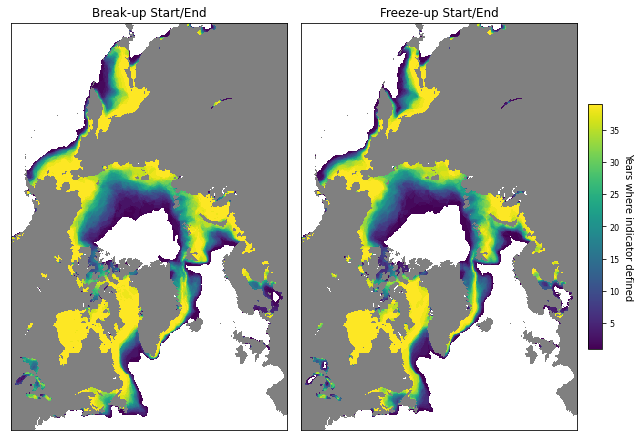

In [23]:
output_format = "png"
#output_format = "eps"

make_totals_maps(
    fubu,
    ["breakup_start", "freezeup_start"],
    landmask,
    # landmask_poly,
    # meta,
    ["Break-up Start/End", "Freeze-up Start/End"],
    content_dir.joinpath(f"Johnson_Eicken_totals_maps.{output_format}"),
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/Steele_totals_maps.png


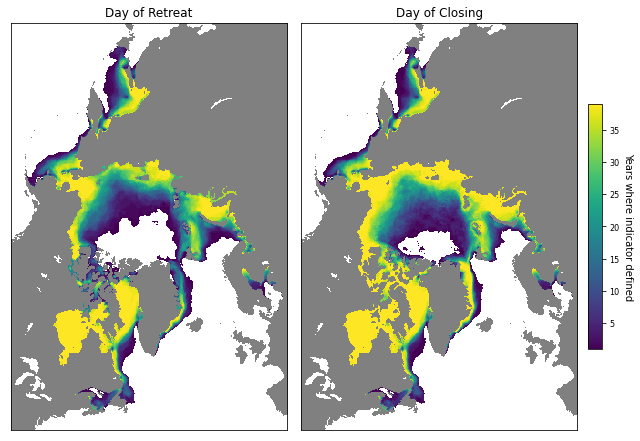

In [24]:
output_format = "png"
#output_format = "eps"

make_totals_maps(
    orac,
    ["DOR", "DOC"],
    landmask,
    # landmask_poly,
    # meta,
    ["Day of Retreat", "Day of Closing"],
    content_dir.joinpath(f"Steele_totals_maps.{output_format}"),
)


In [115]:
def prep_isl_arr(arr, landmask):
    mean_arr = np.nanmean(arr, 0)
    mean_arr[np.isnan(mean_arr)] = 0
    
    return np.ma.masked_where(landmask, mean_arr)

## Ice season length maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/ice_season_length_maps.png


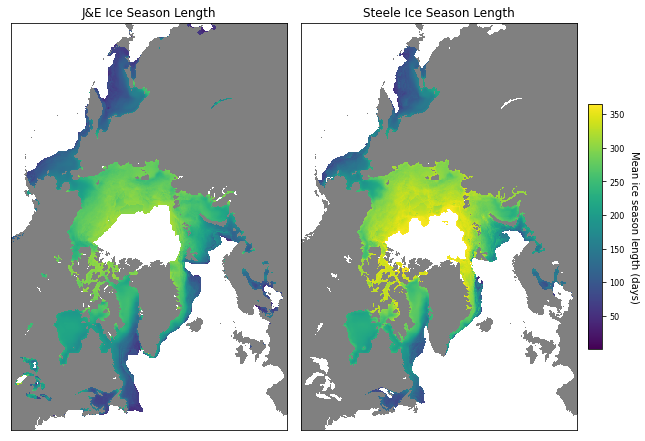

In [26]:
output_format = "png"
#output_format = "eps"

fubu_isl = (fubu["breakup_end"].values + 365) - fubu["freezeup_start"].values
orac_isl = (orac["DOR"].values + 365) - orac["DOA"].values

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    isl_arrs = [prep_isl_arr(arr, landmask) for arr in [fubu_isl, orac_isl]]

# plot data
cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad(color="gray")
cmap.set_under(color="white")
fig, axs = plt.subplots(1, 2, figsize=(10, 7.5))

for arr, ax in zip(isl_arrs, axs):
    im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=1, vmax=365)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title("J&E Ice Season Length", fontdict={"fontsize": 12})
axs[1].set_title("Steele Ice Season Length", fontdict={"fontsize": 12})

fig.subplots_adjust(wspace=-0.25, right=0.95, left=0.01)
# cbar_ax = fig.add_axes([0.85, 0.18, 0.1, 0.8])
# cbar = fig.colorbar(im, cax=cbar_ax)
cax = ax.inset_axes([1.04, 0.2, 0.05, 0.6], transform=ax.transAxes)
cbar = fig.colorbar(im, ax=axs, cax=cax, shrink=1.2)
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Mean ice season length (days)", rotation=270, labelpad=14)
# fig.tight_layout()
# initial journal consideration: The Cryosphere, min width 8cm (3.15in)
fig.set_size_inches(10, 7.5)

save_fig(content_dir.joinpath(f"ice_season_length_maps.{output_format}"))

plt.show()

## Mean date lag maps

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/mean_date_lag_maps.png


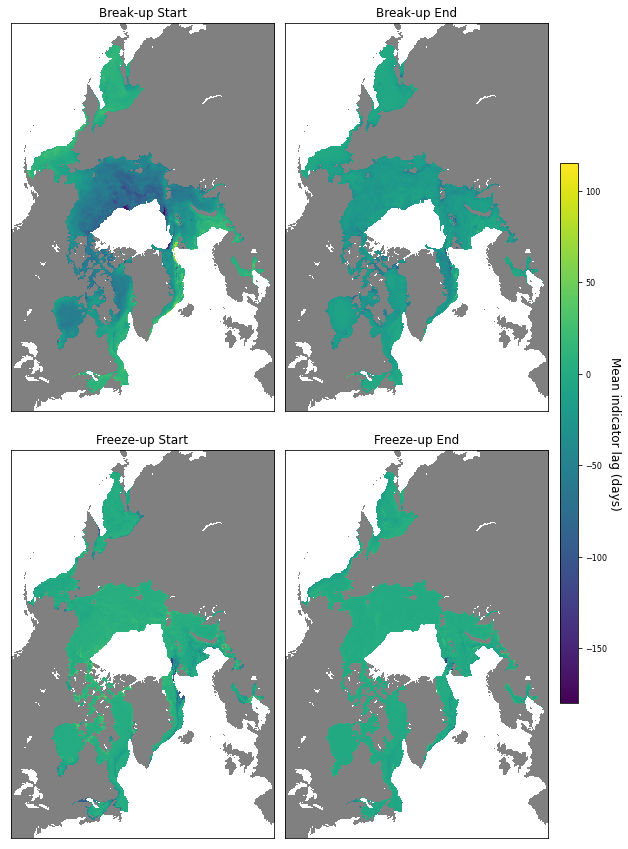

In [888]:
output_format = "png"
#output_format = "eps"

fubu_isl = (fubu["breakup_end"].values + 365) - fubu["freezeup_start"].values
orac_isl = (orac["DOR"].values + 365) - orac["DOA"].values


fubu_orac_di = {
    "breakup_start": "DOO",
    "breakup_end": "DOR",
    "freezeup_start": "DOA", 
    "freezeup_end": "DOC",
}

lag_arrs = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for indicator in list(fubu_orac_di.keys()):
        lag_arr = np.nanmean(
            fubu[indicator].values - orac[fubu_orac_di[indicator]].values, 
            axis=0
        )
        lag_arr[~landmask & np.isnan(lag_arr)] = -9999
        lag_arrs.append(lag_arr)

# plot data
cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad(color="gray")
cmap.set_under(color="white")
fig, axs = plt.subplots(2, 2, figsize=(10, 15))

for arr, ax in zip(lag_arrs, axs.flatten()):
    im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=-180, vmax=115)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0, 0].set_title("Break-up Start", fontdict={"fontsize": 12})
axs[0, 1].set_title("Break-up End", fontdict={"fontsize": 12})
axs[1, 0].set_title("Freeze-up Start", fontdict={"fontsize": 12})
axs[1, 1].set_title("Freeze-up End", fontdict={"fontsize": 12})

fig.subplots_adjust(wspace=-0.32, hspace=.1, right=0.95, left=0.01)

cax = fig.add_axes([0.87, 0.25, 0.025, 0.5])
# fig.colorbar(im, cax=cbar_ax)

# cax = ax.inset_axes([1.04, 0, 0.05, 0.6], transform=ax.transAxes)
cbar = fig.colorbar(im, ax=axs, cax=cax, shrink=1.2)
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Mean indicator lag (days)", rotation=270, labelpad=14, fontsize=12)

save_fig(content_dir.joinpath(f"mean_date_lag_maps.{output_format}"))

plt.show()

## Violin plots

Violin plots that are grouped by indicator and colored by algorithm

In [7]:
def get_polygon(row):
    """Create shapely polygon object from row of alternating
    lat/lon coords

    Args:
        pandas series object from df.iterrows() of MASIE regions
        MS Excel file

    returns
        shapely polygon derived from vertices coordinates in row

    Notes:
        designed for use with MASIE_regions_polygon_vertices.xls
    """
    df_di = {"lat": [], "lon": []}
    for idx, value in zip(row.index, row):

        if pd.isnull(value):
            df_di["lat"].append(df_di["lat"][0])
            df_di["lon"].append(df_di["lon"][0])
            break
        if "Lat" in idx:
            df_di["lat"].append(value)
        if "Lon" in idx:
            df_di["lon"].append(value)

    return Polygon(list(zip(df_di["lon"], df_di["lat"])))

In [8]:
masie_fp = base_dir.joinpath("ancillary/MASIE_regions_polygon_vertices.xls")
masie_df = pd.read_excel(masie_fp, skiprows=1)

masie_polys = masie_df[["Region Number Identifier", "Name"]].copy()
for index, row in masie_df.iterrows():
    masie_polys.loc[index, "geometry"] = get_polygon(row)

masie_polys = gpd.GeoDataFrame(masie_polys).set_crs(epsg=4326).to_crs(epsg=3411)
masie_polys = masie_polys.replace(
    {
        "Name": {
            "Baffin Bay/Gulf of St. Lawrence": "Baffin Bay",
            "Canadian Archipelago": "Canadian Arch.",
            "East Siberian Sea": "E. Siberian Sea",
        }
    }
)

In [9]:
# need affine transform for zonal_stats()
with rio.open(f"netcdf:{fubu_fp}:breakup_end") as src:
    affine = src.meta["transform"]

In [10]:
def success_rate(marr):
    """Compute the percentage of non-nan values in masked array

    Args:
        marr: Masked numpy array of raster values within the polygon

    Returns:
        Percentage of non-nan values (i.e. valid dates) in marr

    Notes:
        Intended use is for deriving indicator success rates
        for MASIE regions via rasterstats.zonal_stats function
    """
    # zonal_stats works on masked arrays,
    # so need to set values in mask to nan
    rate = round(marr[~marr.mask].shape[0] / marr.flatten().shape[0], 3) * 100
    if rate == 0:
        rate = None

    return rate


def run_zonal_stats(
    ds, varnames, masie_polys, affine, add_stats={"rate": success_rate}
):
    """Wrapper for the rasterstats.zonal_stats function to 
    compute stats for the polygons in masie_polys and 
    output as tidy data frame

    Args:
        ds (xarray.Dataset): indicator Dataset
        varnames (list): names of variables in ds to summarize
        masie_polys (pandas.DataFrame): polygons of MASIE regions
        affine (array-like): affine transformation for raster
        add_stats (dict): dict of <stat name>: <stat function> for additional
            statistics

    Returns:
        Tidy data frame of stats of "rasters" in ds evaluated over polygons in
            masie_polys
    """
    zs_di = {}
    for varname in varnames:
        zs_di[varname] = [
            zonal_stats(
                masie_polys,
                arr,
                affine=affine,
                nodata=np.nan,
                stats=["mean"],
                add_stats=add_stats,
            )
            for arr in ds[varname].values
        ]

    # unpack values from zs_di into tidy data frame by repeating/tiling
    stats_df = pd.DataFrame(
        {
            "region": np.tile(
                masie_polys["Name"].values, len(varnames) * len(zs_di[varnames[0]])
            ),
            "indicator": np.repeat(
                varnames, len(zs_di[varnames[0]]) * len(zs_di[varnames[0]][0])
            ),
        }
    )

    stat_names = list(zs_di[varnames[0]][0][0].keys())
    for stat in stat_names:
        stats_df[stat] = [
            region_stats[stat]
            for varname in varnames
            for year_stats in zs_di[varname]
            for region_stats in year_stats
        ]

    return stats_df

In [11]:
fubu_zs = run_zonal_stats(
    fubu,
    ["breakup_start", "breakup_end", "freezeup_start", "freezeup_end"],
    masie_polys,
    affine,
)

In [12]:
orac_zs = run_zonal_stats(
    orac, ["DOO", "DOR", "DOA", "DOC"], masie_polys, affine
)

In [13]:
def concat_dict_lists(di_list1, di_list2):
    """Concatenate two equal-length lists of single-valued dicts
    into single list of dicts
    """
    for d1, d2 in zip(di_list1, di_list2):
        d1["mean"] = d2["mean"]
        
    return di_list1
    

In [14]:
# take means of regions for only the cells that have 70% or higher definition rates

# ignore the following regions: baltic, cook inlet, yellow sea, okhotsk
masie_discard = ["Baltic Sea", "Sea of Okhotsk", "Yellow Sea", "Cook Inlet"]
masie_polys_lm = masie_polys[~masie_polys["Name"].isin(masie_discard)]

zs = {"J&E": {}, "Steele": {}}
for group, ds in zip(zs.keys(), [fubu, orac]):
    for variable in list(ds.variables)[:4]:
        # store mask of grid cells that don't meet definition rate threshold
        indicator_arr = ds[variable].values.copy()
        n = indicator_arr.shape[0]
        # array of definition rates for domain
        rate_arr = (~np.isnan(indicator_arr)).sum(axis=0) / n
        invalid_mask = rate_arr < 0.7
        
        zs[group][variable] = []
        for arr in indicator_arr:
            # first, determine success rates of indicators 
            #   (i.e. percentage of pixels in region where indicator was defined)
            # this is done before the mean aggregation below because that relies
            #   on filtering by definition rate
            zs_rates = zonal_stats(
                masie_polys_lm, 
                arr, 
                affine=affine,
                nodata=np.nan, 
                # need to have a stats function specified or it 
                #   will default to multiple stats
                stats=["count"], 
                add_stats={"rate": success_rate},
            )
            # remove count stat before adding
            zs_rates = [{"rate": zs_di["rate"]} for zs_di in zs_rates]
            
            # second, aggregate by mean for only those pixels in a region
            #   that have high enough individual success rate over the years
            # set pixels with success rates < 0.7 to np.nan
            arr[invalid_mask] = np.nan
            # then aggregate and append
            zs_means = zonal_stats(
                masie_polys_lm, 
                arr, 
                affine=affine,
                nodata=np.nan, 
                stats=["mean"],
            )
            # concatenate with success rate list and append
            zs[group][variable].append(concat_dict_lists(zs_rates, zs_means))
        
        all_year_series = []
        for year_stats, year in zip(zs[group][variable], ds["year"].values):
            mean_series = pd.Series({
                region_name: region_stats["mean"] 
                for region_stats, region_name in zip(year_stats, masie_polys.Name)
            }, name = "mean_date")
            mean_series.index.name = "region"
            year_df = mean_series.reset_index()
            year_df["def_rate"] = [region_stats["rate"] for region_stats in year_stats]
            year_df["year"] = year
            year_df["indicator"] = variable
            year_df["group"] = group
            all_year_series.append(year_df)
        
        zs[group][variable] = pd.concat(all_year_series)

zs["J&E"] = pd.concat(zs["J&E"]).reset_index().drop(columns=["level_1", "level_0"])
zs["Steele"] = pd.concat(zs["Steele"]).reset_index().drop(columns=["level_1", "level_0"])
zs_df = pd.concat(zs).reset_index().drop(columns=["level_1", "level_0"])

In [15]:
# modify zonal stats dataframe for plotting

# give indicators better names
fubu_vars_lu = {
    "breakup_start": "Break-up Start",
    "breakup_end": "Break-up End",
    "freezeup_start": "Freeze-up Start", 
    "freezeup_end": "Freeze-up End", 
}
orac_vars_lu = {
    "DOO": "Day of Opening",
    "DOR": "Day of Retreat",
    "DOA": "Day of Advance", 
    "DOC": "Day of Closing", 
}
zs_df = zs_df.replace(fubu_vars_lu).replace(orac_vars_lu)


# specify indicator type for facetting
indicator_type_lu = {
    "Break-up Start": "breakup",
    "Break-up End": "breakup",
    "Freeze-up Start": "freezeup",
    "Freeze-up End": "freezeup",
    "Day of Opening": "breakup",
    "Day of Retreat": "breakup",
    "Day of Advance": "freezeup",
    "Day of Closing": "freezeup",
}

# specify indicator event for grouping by figure
indicator_event_lu = {
    "Break-up Start": "start",
    "Break-up End": "end",
    "Freeze-up Start": "start",
    "Freeze-up End": "end",
    "Day of Opening": "start",
    "Day of Retreat": "end",
    "Day of Advance": "start",
    "Day of Closing": "end",
}

zs_df["indicator_type"] = zs_df["indicator"].copy().replace(indicator_type_lu)
zs_df["indicator_event"] = zs_df["indicator"].copy().replace(indicator_event_lu)
zs_df["fubu_indicator"] = zs_df["indicator_type"].values + "_" + zs_df["indicator_event"].values
# make categorical for ordered plotting
zs_df["fubu_indicator"] = pd.Categorical(zs_df["fubu_indicator"], categories=list(fubu_vars_lu.keys()), ordered=True)

In [16]:
zs_df

,region,mean_date,def_rate,year,indicator,group,indicator_type,indicator_event,fubu_indicator
0,Beaufort Sea,289.241573,12.1,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
1,Chukchi Sea,300.845802,19.3,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
2,E. Siberian Sea,266.102564,1.6,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
3,Laptev Sea,265.295455,4.2,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
4,Kara Sea,288.731876,16.9,1979,Freeze-up Start,J&E,freezeup,start,freezeup_start
...,...,...,...,...,...,...,...,...,...
3739,Baffin Bay,328.444676,8.2,2017,Day of Closing,Steele,freezeup,end,freezeup_end
3740,Canadian Arch.,275.981520,15.2,2017,Day of Closing,Steele,freezeup,end,freezeup_end
3741,Hudson Bay,337.186902,36.2,2017,Day of Closing,Steele,freezeup,end,freezeup_end
3742,Central Arctic,289.920455,9.3,2017,Day of Closing,Steele,freezeup,end,freezeup_end


In [255]:
def make_violin_plots(zs_df, stat_name, palette, legend_loc, ylab, out_fp):
    """Make violin plot from data frame output from run_zonal_stats

    Args:
        zs_df (pandas.DataFrame): output from run_zonal_stats filtered to indicator
        stat_name (str): name of statistic to plot
        palette (str): name of color palette to use
        legend_loc (str): argument to plt.legend for where to place it
        ylab (str): Y-axis label
        out_fp (path-like): absolute path to write location for image

    Returns: None, writes image to out_fp
    """
    # change varnames as specified for display
    fig = plt.figure(figsize=(18, 6))
    ax = sns.violinplot(
        x="region",
        y=stat_name,
        hue="group",
        data=zs_df,
        palette=palette,
        split=True,
        inner="stick",
        linewidth=1,
        color="black",
    )

    # offset tick label placement to help display long region names
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)

    ax.xaxis.labelpad = 15
    # plt.title(title, size=16)
    plt.xlabel("MASIE Region", size=16)
    plt.ylabel(ylab, size=16)
    plt.legend(loc=legend_loc, prop={"size": 14})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    #save_fig(out_fp)
    print(f"figure saved to {out_fp} TEST")

    plt.show()
    
    return

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/mean_doy_violin_plots.png


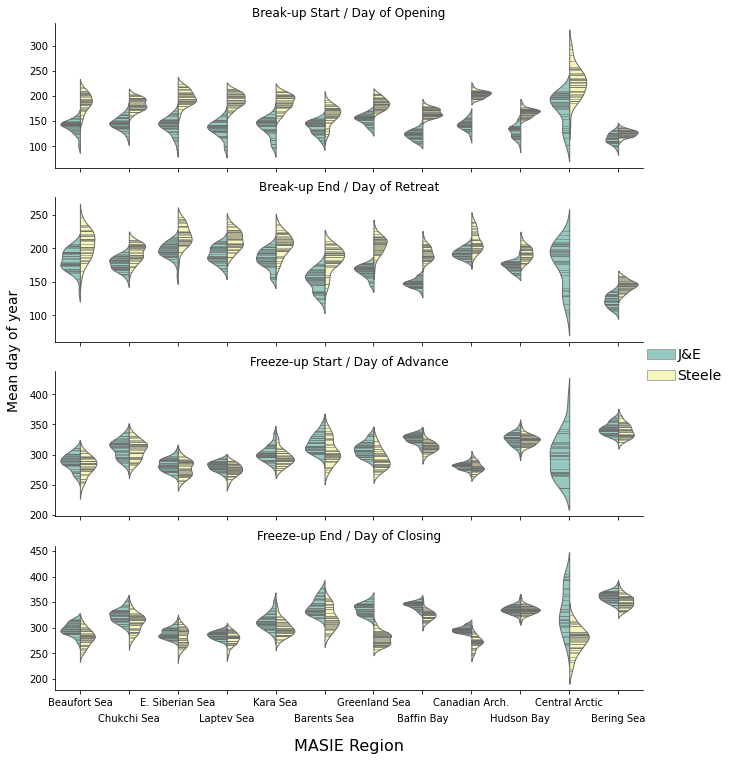

In [24]:
g = sns.catplot(
    x="region",
    y="mean_date",
    hue="group",
    row="fubu_indicator",
    kind="violin",
    data=zs_df,
    palette="Set3",
    split=True,
    inner="stick",
    linewidth=1,
    color="black",
    height=2.5, 
    aspect=3.6,
    sharey=False,
    legend=False,
)

axes = g.axes.flatten()
titles = [
    "Break-up Start / Day of Opening",
    "Break-up End / Day of Retreat",
    "Freeze-up Start / Day of Advance",
    "Freeze-up End / Day of Closing",
]
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_ylabel("")
    

# offset tick label placement to help display long region names
for tick in axes[3].xaxis.get_major_ticks()[1::2]:
    tick.set_pad(20)

axes[3].xaxis.labelpad = 15
axes[3].xaxis.get_label().set_fontsize(13)
plt.xlabel("MASIE Region", size=16)
g.fig.text(-0.01, 0.51, "Mean day of year", va="center", rotation="vertical", fontsize=14)
g.add_legend(title="", fontsize=14, bbox_to_anchor=(1, 0.49), loc="right", handletextpad=0.2)

g.fig.set_size_inches(10, 10)

save_fig(content_dir.joinpath("mean_doy_violin_plots.png"))

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/definition_rate_violin_plots.png


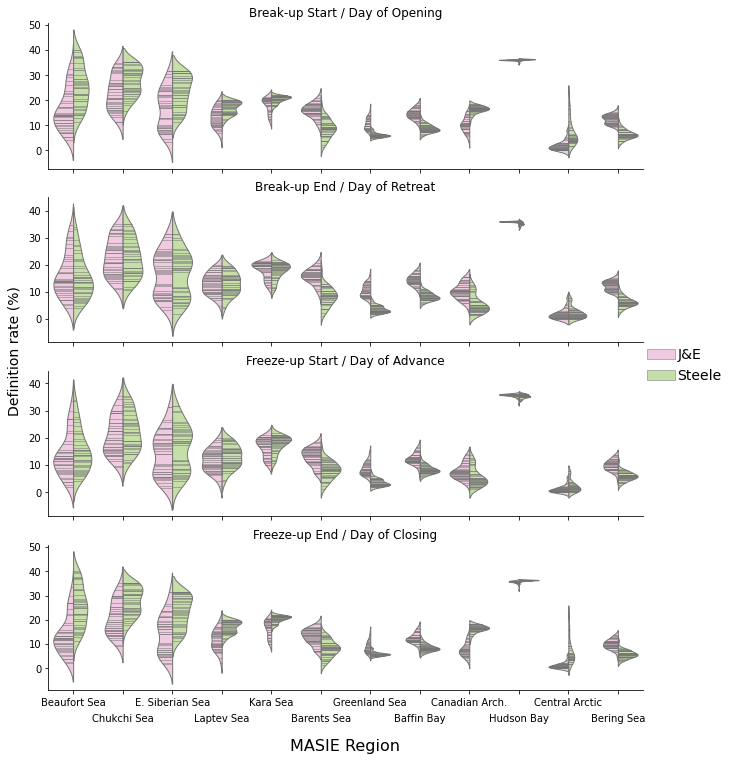

In [192]:
g = sns.catplot(
    x="region",
    y="def_rate",
    hue="group",
    row="fubu_indicator",
    kind="violin",
    data=zs_df,
    palette="PiYG",
    split=True,
    inner="stick",
    linewidth=1,
    color="black",
    height=2.5, 
    aspect=3.6,
    sharey=False,
    legend=False,
)

axes = g.axes.flatten()
titles = [
    "Break-up Start / Day of Opening",
    "Break-up End / Day of Retreat",
    "Freeze-up Start / Day of Advance",
    "Freeze-up End / Day of Closing",
]
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_ylabel("")
    
# offset tick label placement to help display long region names
for tick in axes[3].xaxis.get_major_ticks()[1::2]:
    tick.set_pad(20)

axes[3].xaxis.labelpad = 15
axes[3].xaxis.get_label().set_fontsize(13)
plt.xlabel("MASIE Region", size=16)
g.fig.text(-0.01, 0.51, "Definition rate (%)", va="center", rotation="vertical", fontsize=14)
g.add_legend(title="", fontsize=14, bbox_to_anchor=(1, 0.49), loc="right", handletextpad=0.2)

g.fig.set_size_inches(10, 10)

save_fig(content_dir.joinpath("definition_rate_violin_plots.png"))

## MASIE mean date histograms

Histograms of mean indicator dates for a subset of MASIE regions

In [293]:
def get_data(ma):
    """Helper function for getting only valid data
    from a masked array
    
    Args:
        ma (numpy.ma.masked_array): masked array
    
    Returns:
        array where all masked values are set to np.nan
    """
    ma.data[ma.mask == True] = np.nan
    
    return ma.data


def get_zonal_pixel_means(ds, names_lu, polys, affine):
    """Get the means of pixels within polygons using rasterstats.zonal_stats
    
    Args:
        ds (xarray.dataset): indicators dataset
        names_lu (dict): a names lookup structured as {<dataset varname>: <new varname>}
        polys (pandas.DataFrame): a data.frame of polygon geometries
        
    Returns:
        
    """
    zonal_pixel_means = {}
    for ds_varname, new_varname in zip(names_lu.keys(), names_lu.values()):
        # for each variable (indicator), 
        # use zonal_stats to get the data for a single year
        data_zs = [zonal_stats(
            polys,
            arr, 
            affine=affine, # same affine transform
            nodata=np.nan, 
            add_stats={"data": get_data}
        ) for arr in ds[ds_varname].values]
        
        # and unpack years to concatenate all data
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            
            zonal_pixel_means[new_varname] = {
                row[1]["Name"]: np.nanmean(
                    np.stack([year_stats[row[0]]["data"] for year_stats in data_zs]),
                    axis=0
                )
                for row in polys.iterrows()
            }
    
    return zonal_pixel_means

In [43]:
masie_keep_hist = ["Beaufort Sea", "Chukchi Sea", "E. Siberian Sea", "Laptev Sea"]
masie_polys_hist = masie_polys[masie_polys["Name"].isin(masie_keep_hist)]

fubu_names_lu = {
    "freezeup_start": "Freeze-up Start", 
    "freezeup_end": "Freeze-up End", 
    "breakup_start": "Break-up Start", 
    "breakup_end": "Break-up End",
}
fubu_masie_pixel_means = get_zonal_pixel_means(fubu, fubu_names_lu, masie_polys_hist, affine)
    
orac_names_lu = {
    "DOA": "Day of Advance", 
    "DOC": "Day of Closing", 
    "DOO": "Day of Opening", 
    "DOR": "Day of Retreat",
}
orac_masie_pixel_means = get_zonal_pixel_means(orac, orac_names_lu, masie_polys_hist, affine)

In [44]:
def remove_nan(arr):
    return arr[~np.isnan(arr)]

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_mean_histograms.png


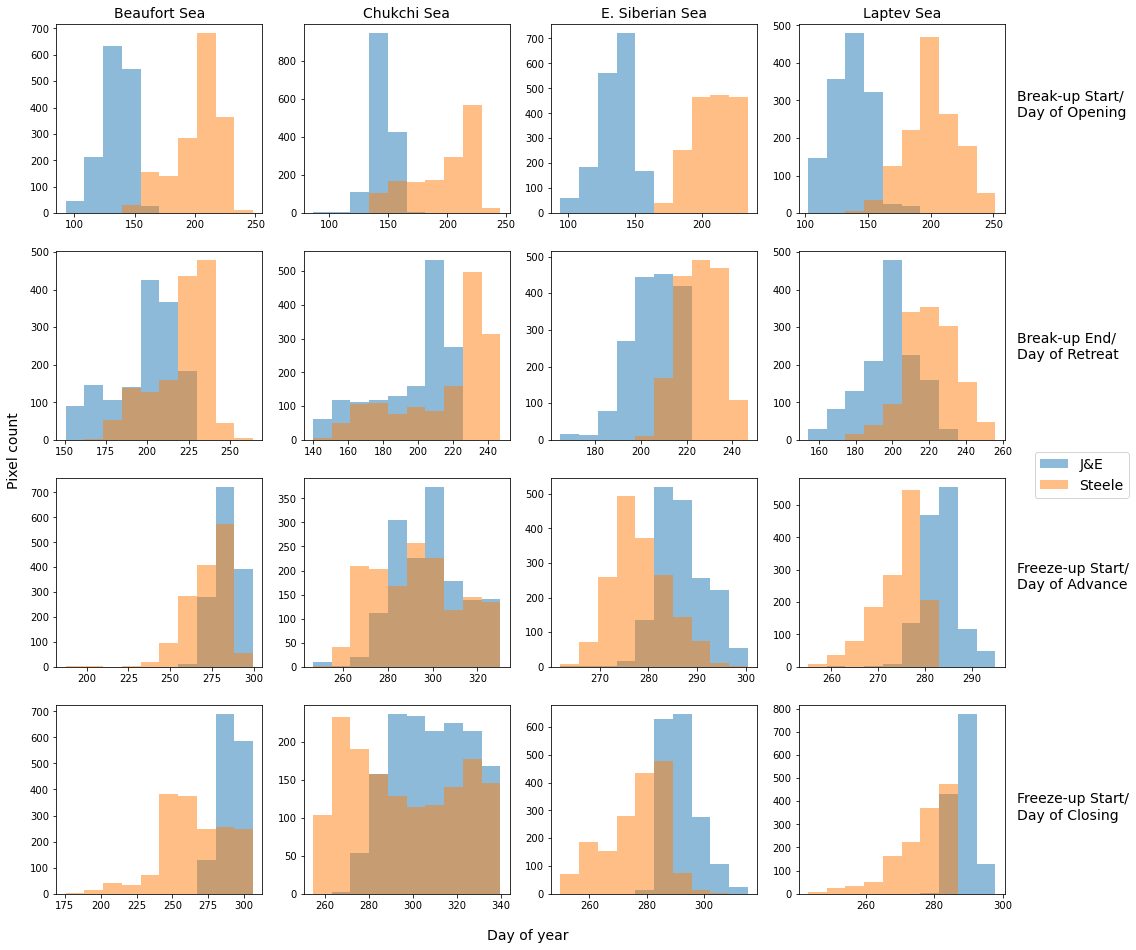

In [46]:
fubu_varnames = ["Break-up Start", "Break-up End", "Freeze-up Start", "Freeze-up End"]

orac_varname_lu = {
    "Freeze-up Start": "Day of Advance",
    "Freeze-up End": "Day of Closing",
    "Break-up Start": "Day of Opening",
    "Break-up End": "Day of Retreat",
}

fig, axs = plt.subplots(4, 4, figsize=(17,16))
for varname, i in zip(fubu_varnames, range(4)):
    for region_name, j in zip(fubu_masie_pixel_means[varname], range(4)):
        fubu_arr = remove_nan(fubu_masie_pixel_means[varname][region_name])
        orac_varname = orac_varname_lu[varname]
        orac_arr = remove_nan(orac_masie_pixel_means[orac_varname][region_name])
        counts, bins = np.histogram(np.concatenate([fubu_arr, orac_arr]))
        axs[(i,j)].hist(fubu_arr, alpha=0.5, label=varname, bins=bins)
        axs[(i,j)].hist(orac_arr, alpha=0.5, label=orac_varname, bins=bins)
        if i == 0:
            axs[(i,j)].set_title(region_name, {"fontsize": 14})
    
# row labels
row_label_x = 0.91
fig.text(row_label_x, 0.81, "Break-up Start/\nDay of Opening", va="center", fontsize=14)
fig.text(row_label_x, 0.6, "Break-up End/\nDay of Retreat", va="center", fontsize=14)
fig.text(row_label_x, 0.4, "Freeze-up Start/\nDay of Advance", va="center", fontsize=14)
fig.text(row_label_x, 0.2, "Freeze-up Start/\nDay of Closing", va="center", fontsize=14)

fig.text(0.51, 0.085, "Day of year", ha="center", fontsize=14)
fig.text(0.085, 0.51, "Pixel count", va="center", rotation="vertical", fontsize=14)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, ["J&E", "Steele"], loc="right", fontsize=14)

save_fig(content_dir.joinpath(f"masie_mean_histograms.{output_format}"))

plt.show()

## Maps for pixel selections for points of interest

Maps depicting the pixels chosen for aggregating values to represent points of interest.

In [845]:
def reproject_poi(poi, in_epsg=4326, out_epsg=3411):
    """Reproject WGS84 coordinates

    Args:
        poi (list/tuple): 2-tuple or 2 item list of
            coordinates of point to reproject in (<lat>, <lon>) format
        in_epsg (int): EPSG code of coords
        out_epsg (int): EPSG to reproject to

    Returns:
        tuple of x, y coordinates in out_epsg, formatted as (<x>, <y>)
    """
    transformer = Transformer.from_crs(in_epsg, out_epsg)

    return transformer.transform(*poi)


def get_offsets_xy(src, xy, offsets):
    """
    returns list of center points of pixels corresponding
    to the offsets
    """
    row, col = src.index(*xy)

    return [src.xy(row + offset[0], col + offset[1]) for offset in offsets]


def get_xy_lims(x, y, scale):
    """Get the x, y limits for a point given the scale specified in the dict"""
    xlims = (x - scale * 1e5, x + scale * 1e5)
    ylims = (y - scale * 1e5, y + scale * 1e5)

    return xlims, ylims


def clip_shore_to_viewing_extent(world_shore, xlims, ylims):
    """Clip the shore polygon to the extent derived from the xy lims"""
    corner_list = [
        (xlims[0], ylims[0]),
        (xlims[0], ylims[1]),
        (xlims[1], ylims[1]),
        (xlims[1], ylims[0]),
        (xlims[0], ylims[0]),
    ]
    bb = Polygon([corner for corner in corner_list])
    bb_df = gpd.GeoDataFrame(geometry=[bb]).set_crs(3411)
    
    return gpd.overlay(bb_df, world_shore, how="intersection")
    

def make_pixel_polygon_from_xy(transform, x, y):
    """Make polygon corresponding to raster pixels
    from given xy centerpoint and the raster's Affine transform
    """
    res = transform[0]
    ul = (x - (res / 2), y + (res / 2))
    corner_list = [
        ul,
        (ul[0] + res, ul[1]),
        (ul[0] + res, ul[1] - res),
        (ul[0], ul[1] - res),
        ul,
    ]
    
    return Polygon([corner for corner in corner_list])


def make_pixel_poly_gdf(transform, xy_list):
    """make GeoPandas DF of pixel polygons from xy list and transform"""
    polys = [make_pixel_polygon_from_xy(transform, *xy) for xy in xy_list]

    return gpd.GeoDataFrame(geometry=polys)


def plot_poi_pixel_polys(
    xy_list, 
    scale, 
    seamask_src, 
    world_shore, 
    poi_name, 
    map_di,
    ax
):
    """Plot the polygons depicting the pixels to be used for the points of interest

    Args:
        xy_list (list): list of 2-tuples of (x, y) coordinates for pixels used
        scale (float): values for scaling viewing window
        seamask_src (rasterio.DatasetReader): seamask raster
        world_shore (geopandas.GeoDataFrame): shapefile of world shoreline
        poi_wgs84 (tuple): lat/lon coordinates in form (lat, lon)
        poi_name (str): display name for point of interest
        ax (matplotlib.axes._subplots.AxesSubplot): axis to plot on
    """
    # unpack map_di values
    poi_wgs84 = map_di["poi_wgs84"]
    poi_name_adj = map_di["poi_name_adj"]
    text = map_di["text"]
    text_adj = map_di["text_adj"]
#     text_bg = map_di["text_bg"]
    
    # get x and y limits for viewing window based on 
    #   scale and poi_xy
    # choose the centerpoint of the viewing window to be the 
    #   midpoint between a pixel selection and the poi
    poi_xy = reproject_poi(poi_wgs84)
    center_xy = [0, 0]
    for i in range(2):
        min_val = np.min((poi_xy[i], xy_list[0][i]))
        center_xy[i] = min_val + (np.max((poi_xy[i], xy_list[0][i])) - min_val) / 2
        
    xlims = (center_xy[0] - scale * 1e5, center_xy[0] + scale * 1e5)
    ylims = (center_xy[1] - scale * 1e5, center_xy[1] + scale * 1e5)

    # get polygon of shoreline within viewing window
    shore_poly = clip_shore_to_viewing_extent(world_shore, xlims, ylims)
    
    # make pixel polygons
    pixel_polys = make_pixel_poly_gdf(seamask_src.transform, xy_list)

    # plot basemap
    show(seamask_src, ax=ax, vmax=10000, cmap="twilight")
    # plot shorelines
    shore_poly.plot(ax=ax, facecolor="none", edgecolor="gray")
    # plot cells that will be used
    pixel_polys.plot(ax=ax, facecolor="none", edgecolor="red")
    
    # show the point of interest
    # this allows to not show a coastal point of interest as a dot,
    #  which is the case for one location -__-
    if poi_name_adj != "none":
        ax.scatter(*poi_xy, color="red")
        # add the adjustments to the point of interest coords
        poi_name_adj = (poi_name_adj[0] * 1e5, poi_name_adj[1] * 1e5)
        poi_name_xy = [sum(x) for x in zip(poi_xy, poi_name_adj)]
        ax.text(*poi_name_xy, poi_name, fontsize=10)

    # display other text
    # add the adjustments for the text coords
    text_adj = [(t[0] * 1e5, t[1] * 1e5) for t in text_adj]
    text_xy = [[sum(x) for x in zip(poi_xy, t_adj)] for t_adj in text_adj]
    _ = [ax.text(*t_xy, t, fontsize=10) for t, t_xy in zip(text, text_xy)]
    
    # add an arrow point north (towards 0, 0)
    # first, get components of arrow pointing towards origin
    #   by dividing by distance from origin to POI
    r = np.sqrt(poi_xy[0] ** 2 + poi_xy[1] ** 2)
    xadj = -poi_xy[0] / (r * 20)
    yadj = -poi_xy[1] / (r * 20)
    # centerpoint in normalized coords for North arrow graphic
    north_cp = (0.15, 0.88)
    # base of arrow
    xytext = (north_cp[0] - xadj, north_cp[1] - yadj)
    xy = (north_cp[0] + xadj, north_cp[1] + yadj)
    ax.annotate(
        "N", 
        xy=xy,
        xycoords=ax.transAxes,
        xytext=xytext,
        textcoords=ax.transAxes,
        fontsize=12,
        arrowprops={"facecolor": "black", "linewidth": 0, "headwidth": 10, "headlength": 8, "shrink": 0},
        ha="center",
        va="center",
    )
    
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    return

In [577]:
gshhs_fp = scratch_dir.joinpath("GSHHS_shp/i/GSHHS_i_L1.shp")
world_shore = gpd.read_file(gshhs_fp)
world_shore = world_shore.to_crs(epsg=3411).set_index("id")

Exception ignored in: <function BaseGeometry.__del__ at 0x7f1af58e7c10>
Traceback (most recent call last):
  File "/home/UA/kmredilla/miniconda3/envs/seaice_noaa_indicators-cenv/lib/python3.8/site-packages/shapely/geometry/base.py", line 241, in __del__
    def __del__(self):
KeyboardInterrupt: 


In [503]:
# open seamask as reader
# made with points_of_interest.ipynb
seamask_src = rio.open(scratch_dir.joinpath("seamask_3411.tif"))

In [ ]:
# open coordinates for points of interest
# made with points_of_interest.ipynb
poi_coords = pd.read_csv(base_dir.joinpath("ancillary/points_of_interest.csv"))

In [843]:
poi_kwargs = {}

for location, df in poi_coords.groupby("location"):
    poi_kwargs[location] = {
        "poi_name": location,
        "xy_list": [
            (row[1]["x"], row[1]["y"]) 
            for row in df.iterrows()
        ],
        "scale": 2,
        "seamask_src": seamask_src,
        "world_shore": world_shore,
    }
    
# add aditional info as dicts for plotting
poi_kwargs["Utqiaġvik"]["map_di"] = {
    "poi_wgs84":(71.2906, -156.7886),
    "poi_name_adj": (-1.25, 0.25),
    "text": ["Chukchi Sea", "Beaufort Sea"],
    "text_adj": [(0.6, 1), (0.5, -1.1)]
}
poi_kwargs["South Chukchi Sea"]["map_di"] = {
    "poi_wgs84": (68.3478, -166.8081),
    "poi_name_adj": "none",
    "text": ["Bering\nStrait", "Chukchi Sea"],
    "text_adj": [(-1.75, 1), (0.5, 0.6)]
}
poi_kwargs["St. Lawrence Island"]["map_di"] = {
    "poi_wgs84": (62.9, -169.6),
    "poi_name_adj": (-0.5, -0.8),
    "text": ["Bering Sea"],
    "text_adj": [(0, 1.25)]
}
poi_kwargs["Prudhoe Bay"]["map_di"] = {
    "poi_wgs84": (70.2, -148.2),
    "poi_name_adj": (-1.2, 0.2),
    "text": ["Beaufort Sea"],
    "text_adj": [(0.5, -1.5)]
}
poi_kwargs["Pevek"]["map_di"] = {
    "poi_wgs84": (69.8, 170.6),
    "poi_name_adj": (-0.8, 0),
    "text": ["East Siberian Sea"],
    "text_adj": [(0, -1.4)]
}
poi_kwargs["Tiksi"]["map_di"] = {
    "poi_wgs84": (71.6, 128.9),
    "poi_name_adj": (0.2, 0),
    "text": ["Laptev Sea"],
    "text_adj": [(-1.75, -1.25)]
}
poi_kwargs["Sabetta"]["map_di"] = {
    "poi_wgs84": (71.3, 72.1),
    "poi_name_adj": (-0.3, -0.4),
    "text": ["Kara Sea"],
    "text_adj": [(-2.75, -2)]
}
poi_kwargs["Mestersvig"]["map_di"] = {
    "poi_wgs84": (72.2, -23.9),
    "poi_name_adj": (-0.75, -0.4),
    "text": ["Greenland Sea"],
    "text_adj": [(0.65, 1)]
}
poi_kwargs["Clyde River"]["map_di"] = {
    "poi_wgs84": (70.3, -68.3),
    "poi_name_adj": (-1.2, 0.25),
    "text": ["Baffin Bay"],
    "text_adj": [(0.8, 0.5)],
#     "text_bg": "#DFD8E1",
}
poi_kwargs["Churchill"]["map_di"] = {
    "poi_wgs84": (58.8, -94.2),
    "poi_name_adj": (-1.2, 0),
    "text": ["Hudson Bay"],
    "text_adj": [(0.7, -0.7)]
}

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_maps.png


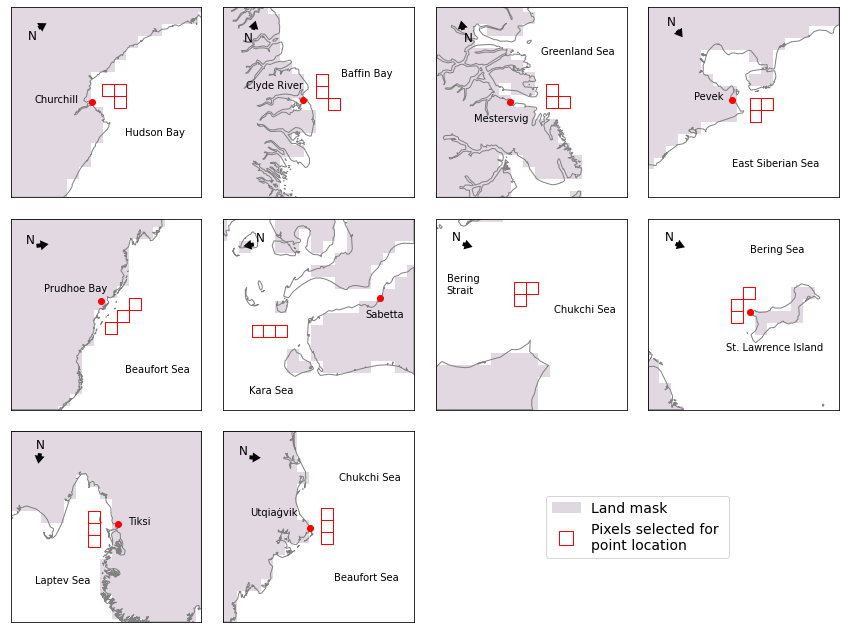

In [846]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for ax, location in zip(axs.flatten(), poi_kwargs.keys()):
    plot_poi_pixel_polys(**poi_kwargs[location], ax=ax)

# delete last two unused subplots
# axs[-1][-1].set_axis_off() 
# axs[-1][-2].set_axis_off() 

gs = axs[2, 2].get_gridspec()
# remove the underlying axes
for ax in axs[2, 2:]:
    ax.remove()
axbig = fig.add_subplot(gs[-1, 2:])

# Clear bottom-right ax
axbig.set_axis_off()  # removes the XY axes

# Manually create legend handles (patches)
land_patch = mpatches.Patch(color="#DFD8E1", label="Land mask")
#pixel_patch = mpatches.Patch(color="red", fill=False, label="Pixels selected for \npoint location")
pixel_line = Line2D(
    [0], [0], 
    marker='s', 
    color="w", 
    label='Pixels selected for \npoint location', 
    markeredgecolor="r", 
    markerfacecolor="w", 
    markersize=14
)

# Add legend to bottom-right ax
axbig.legend(handles=[land_patch, pixel_line], loc="center", fontsize=14)

plt.tight_layout()
save_fig(content_dir.joinpath(f"point_trends_maps.{output_format}"))

plt.show()

## Trend analysis for points of interest

Regress indicator dates against year for the points of interest. Save plots and model fit results.

In [28]:
# load the xy coordinates of point-of-interest pixel selections created in points_of_interest.ipynb
poi_coords = pd.read_csv(base_dir.joinpath("ancillary/points_of_interest.csv"))

In [30]:
def aggregate_pixels(ds, var_dict, xy_list, group, point_name):
    """given an xy_list and variables, make a dataframe by querying an 
    xarray dataset at the given xy locations and aggregating via mean
    """
    # empty list for holding DFs
    df_list = []
    # make a data frame for a single dataset and variable
    with warnings.catch_warnings():
        # ignore "mean of empty slice" warnings
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for var in var_dict.keys():
            df_list.append(
                pd.DataFrame.from_dict(
                    {
                        "point_name": point_name,
                        "indicator": var_dict[var],
                        "year": ds["year"].values,
                        "mean_date": np.nanmean(
                            np.array([
                                ds[var].sel(xc=xy[0], yc=xy[1], method="nearest").values 
                                for xy in xy_list
                            ]), axis=0),
                        "group": group,
                    }
                )
            )
        
    return pd.concat(df_list)

In [31]:
# aggregate pixels according to new points of interest coordinates

fubu_vars = {
    "breakup_start": "Break-up Start / Day of Opening",
    "breakup_end": "Break-up End / Day of Retreat",
    "freezeup_start": "Freeze-up Start / Day of Advance", 
    "freezeup_end": "Freeze-up End / Day of Closing", 
}
orac_vars = {
    "DOO": "Break-up Start / Day of Opening",
    "DOR": "Break-up End / Day of Retreat",
    "DOA": "Freeze-up Start / Day of Advance", 
    "DOC": "Freeze-up End / Day of Closing", 
}

point_data = pd.DataFrame()
for location, df in poi_coords.groupby("location"):
    pixels_xy_list = list(df[["x", "y"]].to_records(index=False))
    point_data = point_data.append(aggregate_pixels(fubu, fubu_vars, pixels_xy_list, "J&E", location))
    point_data = point_data.append(aggregate_pixels(orac, orac_vars, pixels_xy_list, "Steele", location))

In [100]:
def plot_poi_trends(data, indicator, output_format):
    lm = sns.lmplot(
        x="year", 
        y="mean_date", 
        col="point_name", 
        col_wrap=5, 
        hue="group", 
        data=data, 
        sharey=False, 
        height=3, 
        legend=False
    )

    axes = lm.axes.flatten()
    for ax, name in zip(axes.flatten(), data["point_name"].unique()):
        ax.set_title(name)
        ax.set_ylabel("")
        ax.set_xlabel("")

    lm.fig.text(0.485, 1, indicator, ha="center", fontsize=14)
    lm.fig.text(0.485, -0.03, "Year", ha="center", fontsize=14)
    lm.fig.text(-0.01, 0.51, "Mean day of year", va="center", rotation="vertical", fontsize=14)

    lm.fig.subplots_adjust(hspace=0.25)
    plt.subplots_adjust(right=0.88, top=0.92)

    lm.add_legend(title="", fontsize=14, bbox_to_anchor=(1, 0.49), loc="right", handletextpad=0.1)
    
    suffix = indicator.replace(" ", "_").split("_/_")[0].lower().replace("-", "")
    save_fig(content_dir.joinpath(f"point_trends_plots_{suffix}.{output_format}"))

    plt.show()

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_breakup_start.png


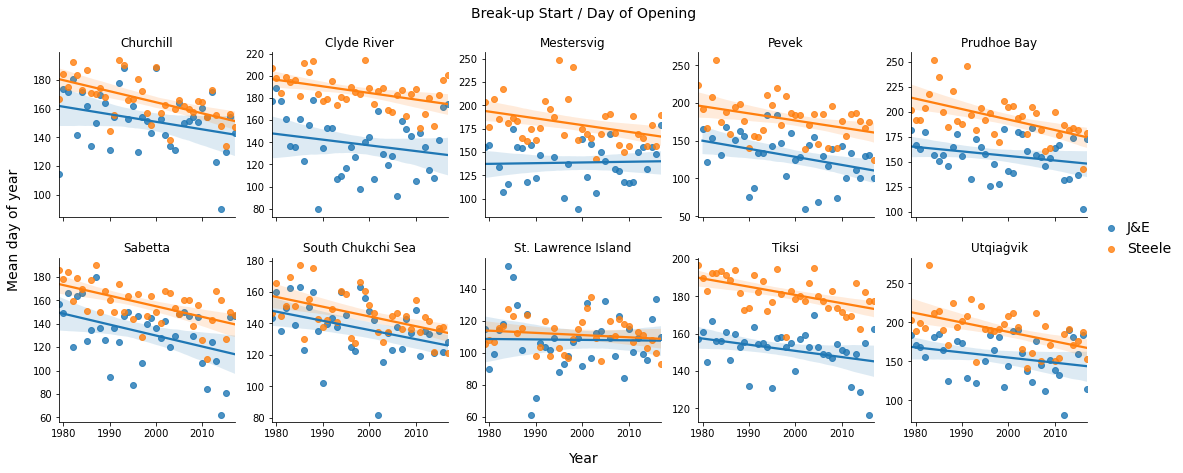

In [101]:
output_format = "png"
#output_format = "eps"

indicator = "Break-up Start / Day of Opening"

plot_poi_trends(
    point_data[point_data["indicator"] == indicator],
    indicator, 
    output_format
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_breakup_end.png


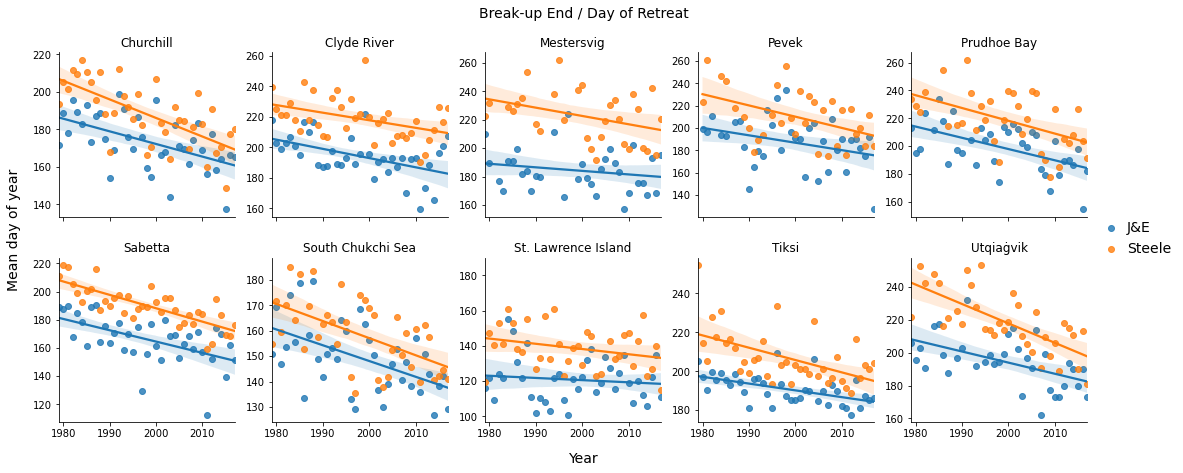

In [102]:
output_format = "png"
#output_format = "eps"

indicator = "Break-up End / Day of Retreat"

plot_poi_trends(
    point_data[point_data["indicator"] == indicator],
    indicator, 
    output_format
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_freezeup_start.png


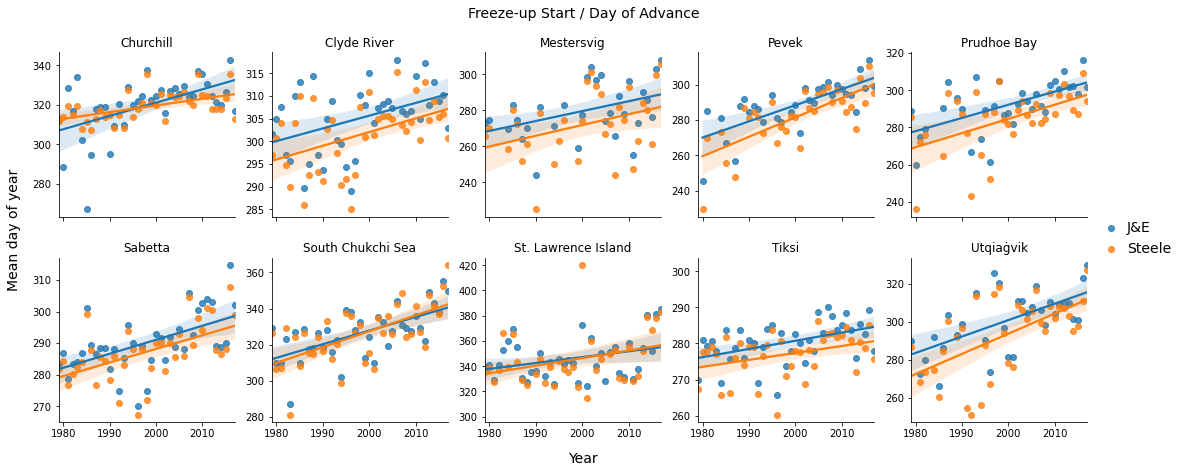

In [103]:
output_format = "png"
#output_format = "eps"

indicator = "Freeze-up Start / Day of Advance"

plot_poi_trends(
    point_data[point_data["indicator"] == indicator],
    indicator, 
    output_format
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_plots_freezeup_end.png


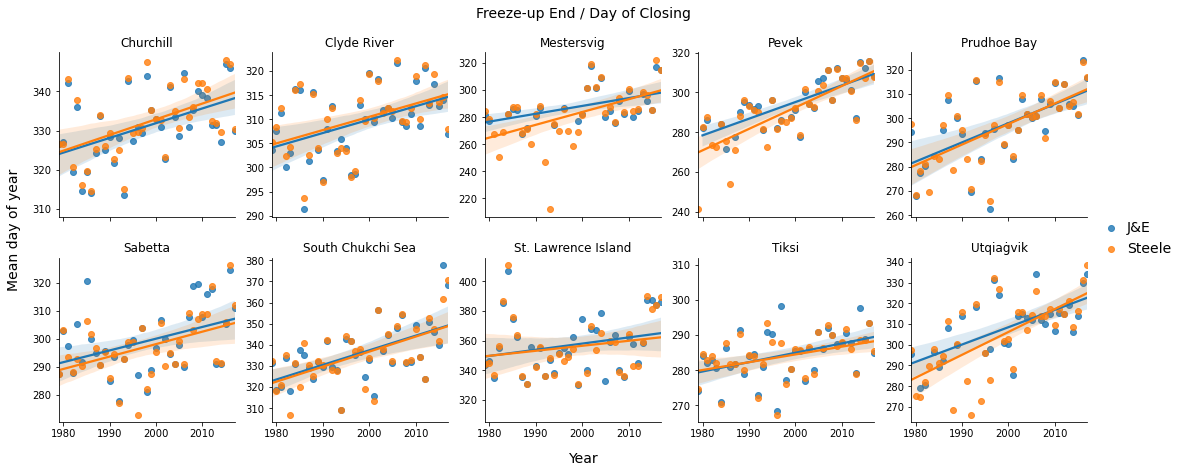

In [104]:
output_format = "png"
#output_format = "eps"

indicator = "Freeze-up End / Day of Closing"

plot_poi_trends(
    point_data[point_data["indicator"] == indicator],
    indicator, 
    output_format
)

In [106]:
# Add column to differentiate indicators between groups
point_data["indicator_name"] = ""
combined_indicators = [
    "Break-up Start / Day of Opening", 
    "Break-up End / Day of Retreat", 
    "Freeze-up Start / Day of Advance", 
    "Freeze-up End / Day of Closing"
]
for indicator in combined_indicators:
    je_ind, steele_ind = indicator.split(" / ")
    point_data.loc[(point_data["group"] == "J&E") & (point_data["indicator"] == indicator), "indicator_name"] = je_ind
    point_data.loc[(point_data["group"] == "Steele") & (point_data["indicator"] == indicator), "indicator_name"] = steele_ind

In [113]:
rows = []
for groups, df in point_data.groupby(["point_name", "group", "indicator_name"]):
    df = df[~np.isnan(df["mean_date"])]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
    if p_value < 0.01:
        p_value = "< 0.01**"
    elif p_value <= 0.05:
        p_value = str(round(p_value, 2)) + "*"
    else:
        p_value = str(round(p_value, 2))
    
    rows.append([*groups, round(slope, 1), round(r_value, 2), p_value])

point_lm_results = pd.DataFrame(rows, columns=["Location", "Indicator Group", "Indicator", "Slope", "r2", "p"])

# do some ordering and save
indicator_names = [i for l in [[ind.split(" / ")[i] for ind in combined_indicators] for i in (0, 1)] for i in l]
point_lm_results["Indicator"] = pd.Categorical(point_lm_results["Indicator"], categories=indicator_names, ordered=True)
point_lm_results.sort_values(["Location", "Indicator Group", "Indicator"])

point_trends_results_fp = content_dir.joinpath("point_trends_results_table.csv")
point_lm_results.to_csv(point_trends_results_fp, index=False)
print(f"Point trends results written to {point_trends_results_fp}")
point_lm_results

Point trends results written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/point_trends_results_table.csv


,Location,Indicator Group,Indicator,Slope,r2,p
0,Churchill,J&E,Break-up End,-0.7,-0.54,< 0.01**
1,Churchill,J&E,Break-up Start,-0.5,-0.30,0.07
2,Churchill,J&E,Freeze-up End,0.4,0.49,< 0.01**
3,Churchill,J&E,Freeze-up Start,0.7,0.53,< 0.01**
4,Churchill,Steele,Day of Advance,0.3,0.52,< 0.01**
...,...,...,...,...,...,...
75,Utqiaġvik,J&E,Freeze-up Start,0.9,0.62,< 0.01**
76,Utqiaġvik,Steele,Day of Advance,1.1,0.60,< 0.01**
77,Utqiaġvik,Steele,Day of Closing,1.1,0.67,< 0.01**
78,Utqiaġvik,Steele,Day of Opening,-1.2,-0.52,< 0.01**


## Trend analysis of MASIE region / point of interest comparison

Plot the trends of the points of interest against the MASIE region averages.

In [491]:
# make a lookup table for region to poi
poi_region_lu = {
    "Churchill": "Hudson Bay",
    "Clyde River": "Baffin Bay",
    "Mestersvig": "Greenland Sea",
    "Pevek": "E. Siberian Sea",
    "Sabetta": "Kara Sea", 
    "St. Lawrence Island": "Bering Sea", 
    "Tiksi": "Laptev Sea",
    "Prudhoe Bay": "Beaufort Sea",
    "Utqiaġvik": "Chukchi Sea",
    "South Chukchi Sea": "Chukchi Sea", 
}

In [492]:
# wrangle the data frames to be concat-able

# subset data frames to J&E before joining
point_data_je = point_data[point_data["group"] == "J&E"].drop(columns="group")
zs_df_je = zs_df[zs_df["group"] == "J&E"].drop(
    columns=["group", "indicator_event", "indicator_type", "fubu_indicator", "def_rate"]
)

# replace inclusive indicator names with just FUBU names
point_data_je["indicator"] = [
    name.split(" / ")[0] for name in point_data_je["indicator"]
]

# add region info using lookup
point_data_je["region"] = point_data_je["point_name"].map(poi_region_lu)

# add location info to region df using reverse lu
zs_df_je["point_name"] = zs_df_je["region"].map(
    dict((v, k) for k, v in poi_region_lu.items()), na_action="ignore"
)
# drop data without point name of interest
zs_df_je = zs_df_je[~zs_df_je["point_name"].isnull()]

# # add variable for coloring by location/region
point_data_je["type"] = "Location"
zs_df_je["type"] = "MASIE\nregion"

# reorder cols and append
poi_masie_df = point_data_je.append(zs_df_je[point_data_je.columns])

# need to copy Chukchi data and re-apply with the South Chukchi Sea location
# since we have two locations in the Chukchi
chukchi_temp = poi_masie_df[
    (poi_masie_df["region"] == "Chukchi Sea")
    & (poi_masie_df["type"] == "MASIE\nregion")
].copy()
chukchi_temp["point_name"] = chukchi_temp["point_name"].replace(
    {"South Chukchi Sea": "Utqiaġvik"}
)
poi_masie_df = poi_masie_df.append(chukchi_temp)

# create a column for displaying both location and region names
poi_masie_df["region_location"] = poi_masie_df["point_name"] + " /\n" + poi_masie_df["region"]

In [184]:
def plot_masie_poi_trends(data, indicator, output_format):
    p = sns.color_palette()

    lm = sns.lmplot(
        x="year", 
        y="mean_date", 
        col="region_location", 
        col_wrap=5, 
        hue="type", 
        data=data, 
        sharey=False, 
        height=3, 
        legend=False,
        palette=sns.color_palette([p[0], p[6]])
    )

    axes = lm.axes.flatten()
    for ax, name in zip(axes.flatten(), data["region_location"].unique()):
        ax.set_title(name)
        ax.set_ylabel("")
        ax.set_xlabel("")

    lm.fig.text(0.47, 1.025, indicator, ha="center", fontsize=14)
    lm.fig.text(0.485, -0.03, "Year", ha="center", fontsize=14)
    lm.fig.text(-0.01, 0.51, "Mean day of year", va="center", rotation="vertical", fontsize=14)

    lm.fig.subplots_adjust(hspace=0.25)
    plt.subplots_adjust(right=0.88, top=0.92)

    lm.add_legend(title="", fontsize=14, bbox_to_anchor=(1, 0.49), loc="right", handletextpad=0.1)
    
    suffix = indicator.replace(" ", "_").lower().replace("-", "")
    save_fig(content_dir.joinpath(f"masie_point_trends_plots_{suffix}.{output_format}"))

    plt.show()

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_breakup_start.png


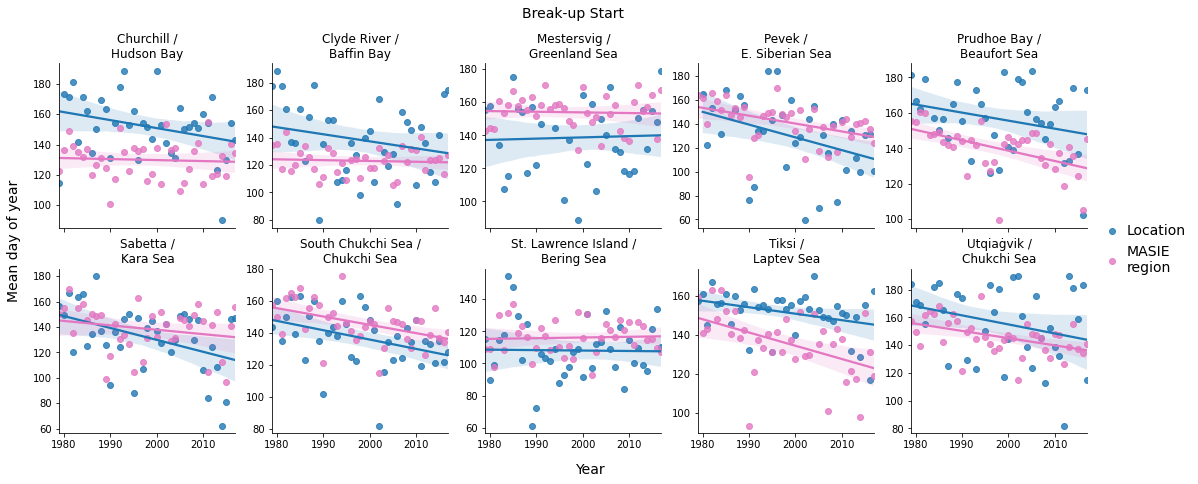

In [497]:
output_format = "png"
#output_format = "eps"

indicator = "Break-up Start"

plot_masie_poi_trends(
    poi_masie_df[poi_masie_df["indicator"] == indicator],
    indicator, 
    output_format
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_breakup_end.png


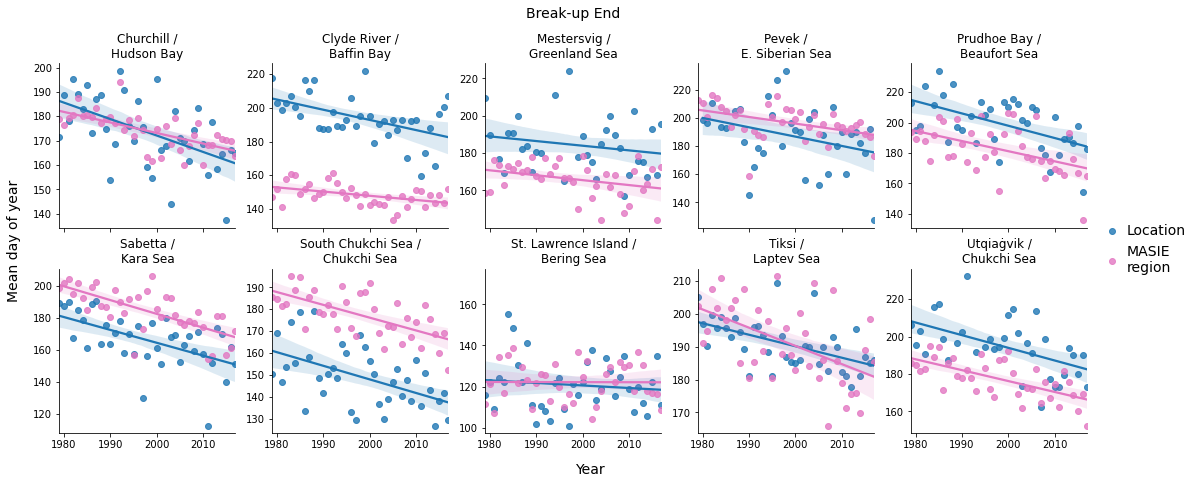

In [498]:
output_format = "png"
#output_format = "eps"

indicator = "Break-up End"

plot_masie_poi_trends(
    poi_masie_df[poi_masie_df["indicator"] == indicator],
    indicator, 
    output_format
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_freezeup_start.png


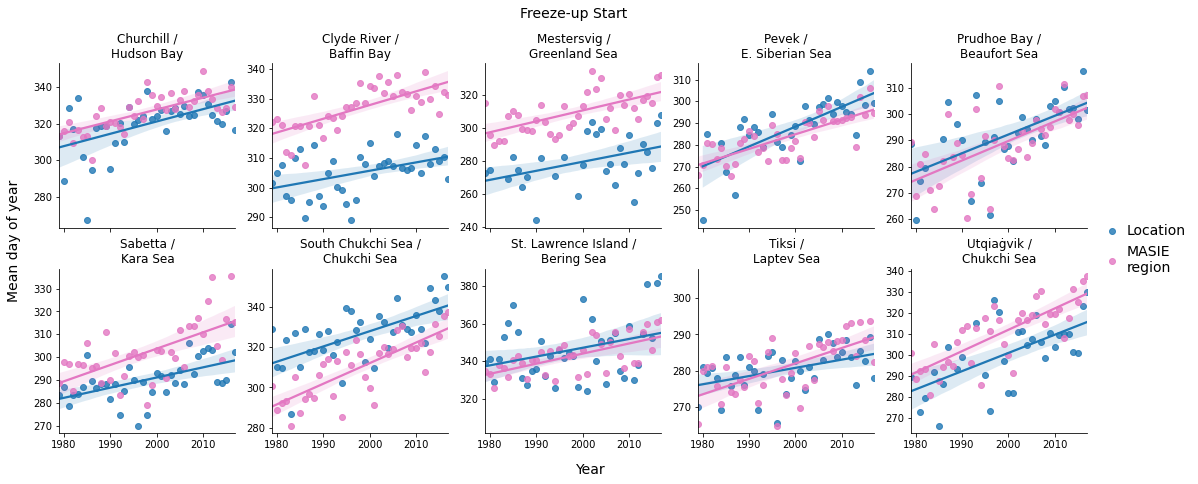

In [499]:
output_format = "png"
#output_format = "eps"

indicator = "Freeze-up Start"

plot_masie_poi_trends(
    poi_masie_df[poi_masie_df["indicator"] == indicator],
    indicator, 
    output_format
)

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_point_trends_plots_freezeup_end.png


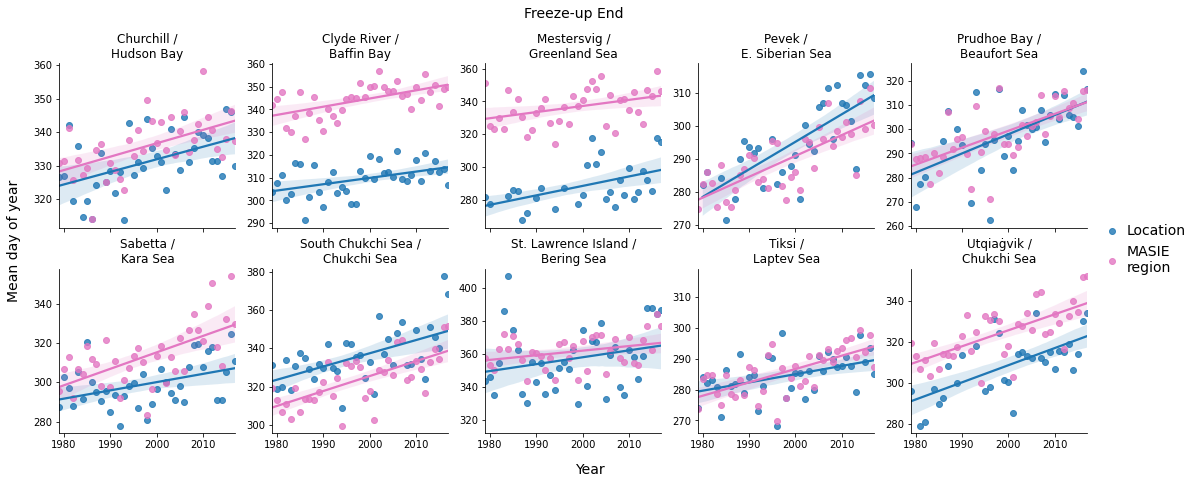

In [500]:
output_format = "png"
#output_format = "eps"

indicator = "Freeze-up End"

plot_masie_poi_trends(
    poi_masie_df[poi_masie_df["indicator"] == indicator],
    indicator, 
    output_format
)

## MASIE trends plots

In [126]:
# ignore the following regions: baltic, cook inlet, yellow sea, okhotsk
masie_discard = ["Baltic Sea", "Sea of Okhotsk", "Yellow Sea", "Cook Inlet"]
masie_polys_lm = masie_polys[~masie_polys["Name"].isin(masie_discard)]

zs = {"J&E": {}, "Steele": {}}
for group, ds in zip(zs.keys(), [fubu, orac]):
    for variable in list(ds.variables)[:4]:
        # store mask of grid cells that don't meet definition rate threshold
        ind_arr = ds[variable].values.copy()
        n = ind_arr.shape[0]
        # definition rate
        rate_arr = (~np.isnan(ind_arr)).sum(axis=0) / n
        invalid_mask = rate_arr < 0.7
        zs[group][variable] = []
        for arr in ind_arr:
            arr[invalid_mask] = np.nan
            zs[group][variable].append(
                zonal_stats(
                    masie_polys_lm, 
                    arr, 
                    affine=affine,
                    nodata=np.nan, 
                    stats=["mean"],
                )
            )
        all_year_series = []
        for year_means, year in zip(zs[group][variable], ds["year"].values):
            year_series = pd.Series({
                region_name: list(region_mean.values())[0] 
                for region_mean, region_name in zip(year_means, masie_polys.Name)
            }, name = "mean_date")
            year_series.index.name = "region"
            year_df = year_series.reset_index()
            year_df["year"] = year
            year_df["indicator"] = variable
            year_df["group"] = group
            all_year_series.append(year_df)
        
        zs[group][variable] = pd.concat(all_year_series)

zs["J&E"] = pd.concat(zs["J&E"]).reset_index().drop(columns=["level_1", "level_0"])
zs["Steele"] = pd.concat(zs["Steele"]).reset_index().drop(columns=["level_1", "level_0"])
zs_df = pd.concat(zs).reset_index().drop(columns=["level_1", "level_0"])
zs_df = zs_df.replace(fubu_vars).replace(orac_vars)

In [66]:
def plot_masie_trends(indicator_zs_df):
    lm = sns.lmplot(x="year", y="mean_date", col_wrap=4, col="region", hue="group", data=indicator_zs_df, sharey=False, height=3, legend=False)

    axes = lm.axes.flatten()
    for ax in axes:
        ax.set_title(ax.get_title().split(" = ")[1])
        ax.set_ylabel("")
        ax.set_xlabel("")

    lm.fig.text(0.46, -0.01, "Year", ha="center", fontsize=14)
    lm.fig.text(-0.01, 0.5, "Mean day of year", va="center", rotation="vertical", fontsize=14)

    # lm._legend.set_title("")
    # plt.setp(lm._legend.get_texts(), fontsize=16)
    lm.fig.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(right=0.9, top=0.92)

    lm.add_legend(title="", fontsize=14, frameon=True, borderaxespad=0.25)
    
    return lm

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_breakup_start_trends_plots.png


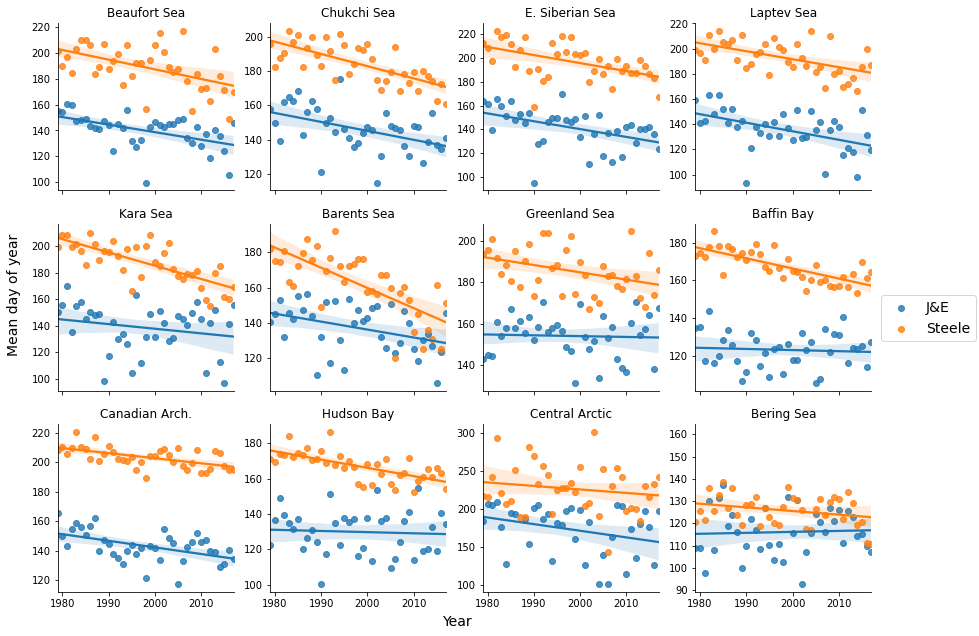

In [67]:
output_format = "png"
#output_format = "eps"

indicator_groups = list(fubu_vars.values())

masie_lm = plot_masie_trends(zs_df[zs_df["indicator"] == indicator_groups[0]])

save_fig(content_dir.joinpath(f"masie_breakup_start_trends_plots.{output_format}"))

plt.show()

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_breakup_end_trends_plots.png


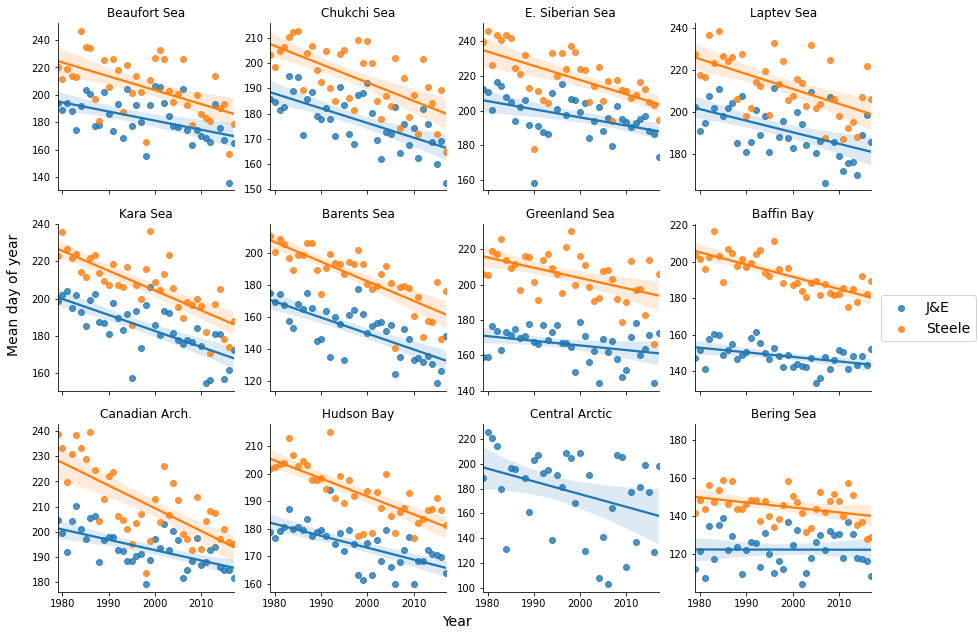

In [68]:
output_format = "png"
#output_format = "eps"

masie_breakup_end_lm = plot_masie_trends(zs_df[zs_df["indicator"] == indicator_groups[1]])

save_fig(content_dir.joinpath(f"masie_breakup_end_trends_plots.{output_format}"))

plt.show()

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_freezeup_start_trends_plots.png


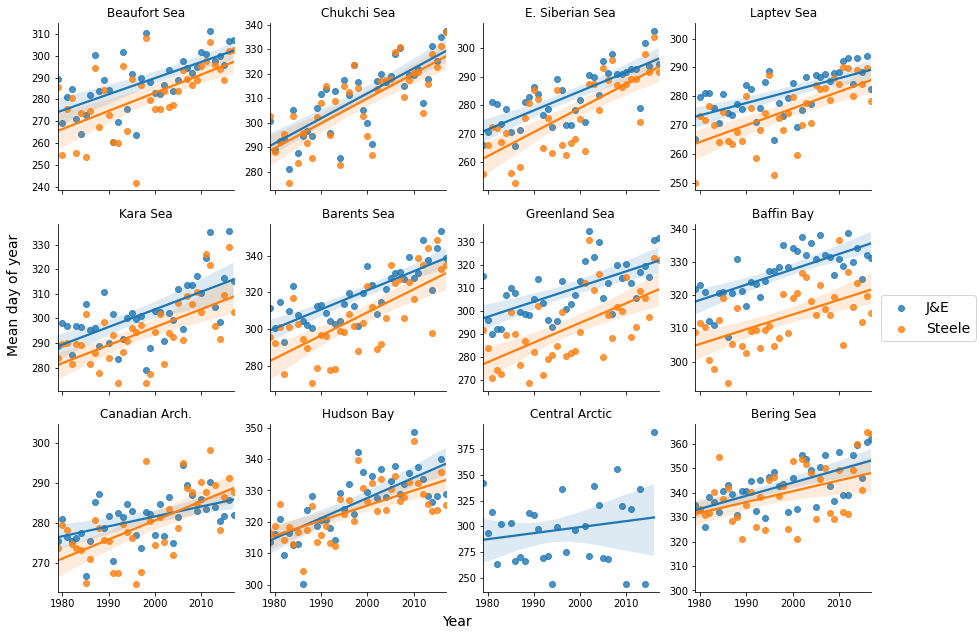

In [69]:
output_format = "png"
#output_format = "eps"

masie_lm = plot_masie_trends(zs_df[zs_df["indicator"] == indicator_groups[2]])

save_fig(content_dir.joinpath(f"masie_freezeup_start_trends_plots.{output_format}"))

plt.show()

Plot written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_freezeup_end_trends_plots.png


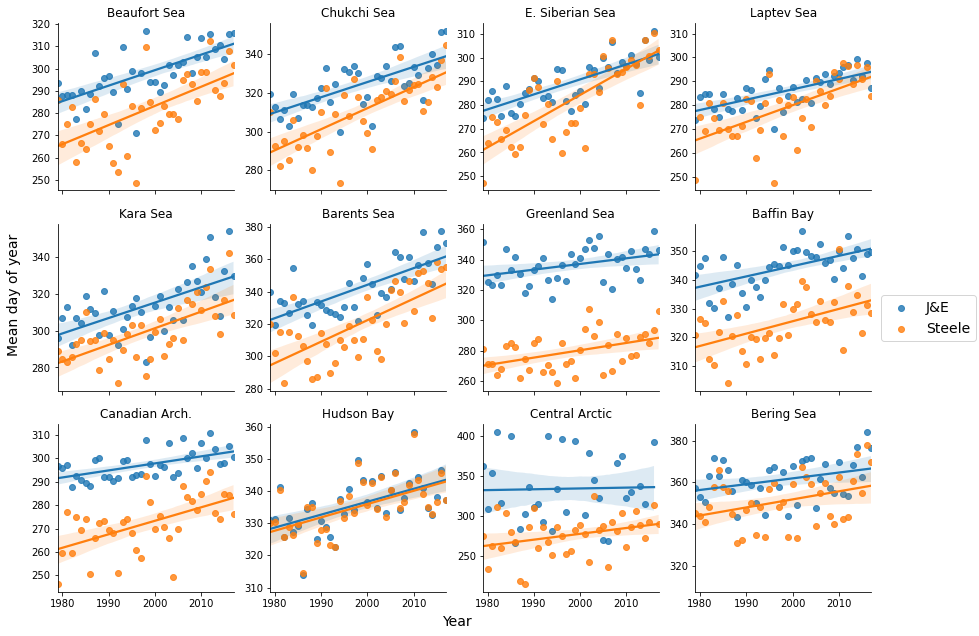

In [70]:
output_format = "png"
#output_format = "eps"

masie_lm = plot_masie_trends(zs_df[zs_df["indicator"] == indicator_groups[3]])

save_fig(content_dir.joinpath(f"masie_freezeup_end_trends_plots.{output_format}"))

plt.show()

In [71]:
# discard regions with no indicators
df = df[~np.isnan(df["mean_date"])]
rows = []
for groups, df in zs_df.groupby(["region", "group", "indicator"]):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df["year"], df["mean_date"])
    if p_value < 0.01:
        p_value = "< 0.01**"
    elif p_value <= 0.05:
        p_value = str(round(p_value, 2)) + "*"
    else:
        p_value = str(round(p_value, 2))
    
    rows.append([*groups, round(slope, 1), round(r_value, 2), p_value])

masie_lm_results = pd.DataFrame(rows, columns=["Region", "Indicator Group", "Indicator", "Slope", "r2", "p"])
masie_trends_results_fp = content_dir.joinpath("masie_trends_results_table.csv")
masie_lm_results.to_csv(masie_trends_results_fp)
print(f"MASIE trends results written to {masie_trends_results_fp}")
masie_lm_results

MASIE trends results written to /workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/final_products/manuscript_content/masie_trends_results_table.csv


,Region,Indicator Group,Indicator,Slope,r2,p
0,Baffin Bay,J&E,Break-up End / Day of Retreat,-0.2,-0.44,< 0.01**
1,Baffin Bay,J&E,Break-up Start / Day of Opening,-0.1,-0.07,0.67
2,Baffin Bay,J&E,Freeze-up End / Day of Closing,0.4,0.57,< 0.01**
3,Baffin Bay,J&E,Freeze-up Start / Day of Advance,0.5,0.71,< 0.01**
4,Baffin Bay,Steele,Break-up End / Day of Retreat,-0.7,-0.77,< 0.01**
...,...,...,...,...,...,...
91,Laptev Sea,J&E,Freeze-up Start / Day of Advance,0.4,0.64,< 0.01**
92,Laptev Sea,Steele,Break-up End / Day of Retreat,-0.7,-0.58,< 0.01**
93,Laptev Sea,Steele,Break-up Start / Day of Opening,-0.6,-0.55,< 0.01**
94,Laptev Sea,Steele,Freeze-up End / Day of Closing,0.7,0.64,< 0.01**


# Appendix

This notebook provides supplementary material for the manuscript. 

## Steele indicators differences in definition totals

This section presents a summary of the differences between the Steele indicator groups total definition counts (freeze-up group: Day of Advance, Day of Closing; break-up group: Day of Opening, Day of Retreat). For the totals maps figure, we only included the Day of Opening / Day of Closing the differences between definition rates are  small to warrant depiction of totals for all four indicators. This sectin simply justifies that exclusion:

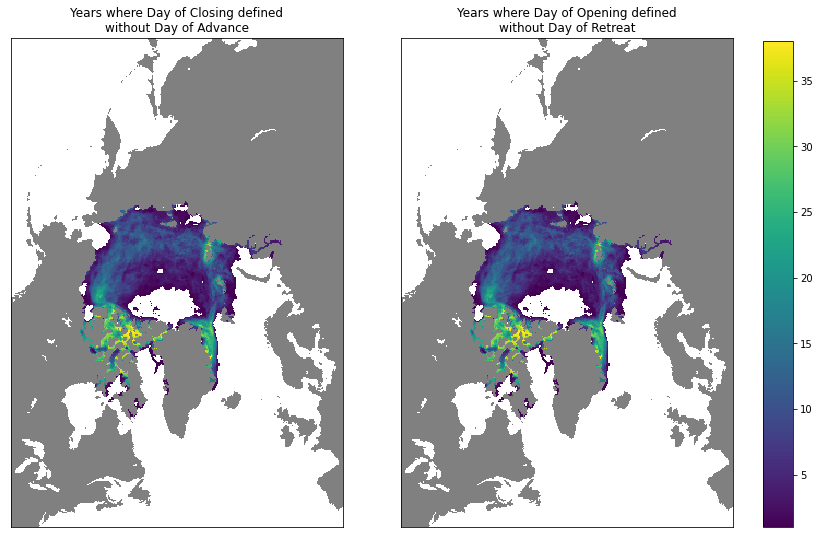

In [48]:
import copy
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


def prep_exclusive_counts(orac_ds, indicator1, indicator2):
    """Count instances where indicator1 is defined but not
    indicator2"""
    # create array for counting and set exclusive 
    # instances to 1 and sum to count
    exclusive_arr = np.zeros_like(orac_ds["DOC"].values)
    exclusive_arr[
        (orac_ds[indicator1].values > 0) & 
        (orac_ds[indicator2].values <= 0)
    ] = 1
    
    # prep for plotting with masking
    plot_arr = np.ma.masked_where(
        orac_ds["DOA"].values[0] == -4, 
        exclusive_arr.sum(axis=0)
    )
    
    return plot_arr


def plot_exclusive_counts(plot_arrs, titles):
    cmap = copy.copy(plt.cm.get_cmap("viridis"))
    cmap.set_under(color="white")
    cmap.set_bad(color="gray")
    fig, axs = plt.subplots(1, 2, figsize=(14, 9))
    for arr,ax,title in zip(plot_arrs, axs, titles):
        im = ax.imshow(arr, interpolation="none", cmap=cmap, vmin=1, vmax=38)
        ax.title.set_text(title)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(wspace=0)
    cbar_ax = fig.add_axes([0.9, 0.125, 0.03, 0.75])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    return


os.environ["BASE_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/"
base_dir = Path(os.getenv("BASE_DIR"))
# computed fubu dates fp
# fubu_fp = base_dir.joinpath("nsidc_0051/outputs/nsidc_0051_1979-2019_fubu.nc")
# path to sample converted file to get landmask array
#converted_fp = list(base_dir.joinpath("nsidc_0051/prepped").glob("*"))[0]

# load fubu dates netCDF
# set up meta data for saving GeoTIFFs
# with rio.open(converted_fp) as src:
#     # defined for global reference
#     fubu_landmask = src.read(1) == 254
#     # meta = src.meta

# fubu_ds = xr.load_dataset(fubu_fp)

orac_fp = base_dir.joinpath("nsidc_0747", "arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc")
orac_ds = xr.load_dataset(orac_fp)

# keys in this dict are indicators that may be defined
# even the conjugate indicator is not 
indicator_lu = {"DOC": "DOA", "DOO": "DOR"}
plot_arrs = [prep_exclusive_counts(orac_ds, i, indicator_lu[i]) for i in ["DOC", "DOO"]]
   
# plot data
titles = [
    "Years where Day of Closing defined\nwithout Day of Advance",
    "Years where Day of Opening defined\nwithout Day of Retreat",
]

plot_exclusive_counts(plot_arrs, titles)

But the converse conditions are not true:

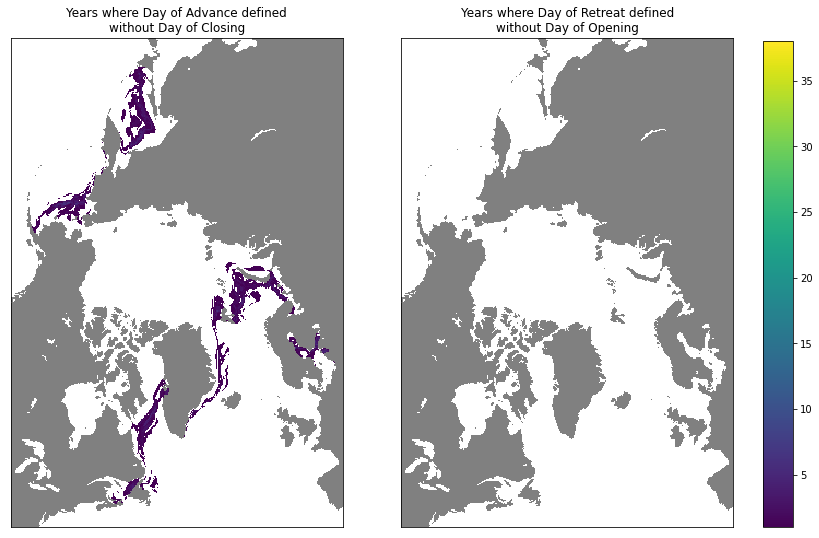

In [49]:
indicator_lu = {"DOA": "DOC", "DOR": "DOO"}
plot_arrs = [prep_exclusive_end_counts(orac_ds, i, indicator_lu[i]) for i in ["DOA", "DOR"]]
    
# plot data
titles = [
    "Years where Day of Advance defined\nwithout Day of Closing",
    "Years where Day of Retreat defined\nwithout Day of Opening",
]

plot_exclusive_counts(plot_arrs, titles)